In [6]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path
from scipy.spatial import cKDTree

category_mapping = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55],  # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14],  # Object
    2: [7, 22, 9, 26, 11, 21],  # Road
    3: [48, 47, 1, 19, 46, 10, 25],  # Sign
    4: [23, 3, 24, 31, 2],  # Terrain
    5: [51, 50, 5, 18],  # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17],  # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    8: [8, 56, 0, 53, 54],  # Void
}

label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

def map_labels(labels: np.ndarray) -> np.ndarray:
    """Convierte etiquetas en categorías"""
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, radius: float = 25.0):
    """ Carga la nube de puntos y mantiene los índices originales tras el filtrado """
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    return points[mask], np.where(mask)[0]  # Devolver puntos filtrados y sus índices originales

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    """ Carga etiquetas utilizando los índices originales y las mapea a categorías. """
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])  # Extrae etiquetas correctas según índices originales

def normalize_point_cloud(points):
    """ Normaliza la nube restando la media y dividiendo por la desviación estándar. """
    mean = np.mean(points, axis=0)
    std = np.std(points, axis=0) + 1e-6
    return (points - mean) / std

def divide_into_subnubes(points, labels, original_indices, num_points=16384):
    """ Divide la nube en subnubes de tamaño fijo. Si no se puede dividir al menos una vez, se descarta. """
    num_total = points.shape[0]

    # Si la nube tiene menos de num_points, se descarta completamente
    if num_total < num_points:
        print(f" Descartando nube con {num_total} puntos (menor a {num_points})")
        return []

    # Ajustar a un múltiplo exacto de num_points
    num_valid = num_total - (num_total % num_points)

    # Si después del ajuste sigue sin haber al menos una subnube completa, se descarta
    if num_valid < num_points:
        print(f" Descartando nube con {num_valid} puntos (no alcanza {num_points} tras ajuste)")
        return []

    # Dividir en subnubes exactas
    subnubes = [
        (points[i * num_points: (i + 1) * num_points],
         labels[i * num_points: (i + 1) * num_points],
         original_indices[i * num_points: (i + 1) * num_points])  
        for i in range(num_valid // num_points)
    ]
    
    return subnubes

NUM_POINTS = 16384  # Puedes ajustar según necesidad

def get_file_paths(data_dir: str, extension: str) -> list:
    """Obtiene una lista de archivos con la extensión dada en el directorio."""
    return sorted([str(f) for f in Path(data_dir).glob(f"*.{extension}") if f.is_file()])

class PointCloudDataset(Dataset):
    def __init__(self, bin_dir, label_dir, num_points=NUM_POINTS, mode='train'):
        """
        Dataset que carga nubes de puntos y etiquetas desde carpetas.

        Args:
            bin_dir (str): Ruta del directorio con archivos .bin.
            label_dir (str): Ruta del directorio con archivos .label.
            num_points (int): Número de puntos por subnube.
            mode (str): 'train' o 'val' para definir el tipo de muestreo.
        """
        self.bin_files = get_file_paths(bin_dir, "bin")
        self.label_files = get_file_paths(label_dir, "label")
        self.num_points = num_points
        self.mode = mode

        # Validación de que haya la misma cantidad de archivos .bin y .label
        assert len(self.bin_files) == len(self.label_files), \
            f"Error: Diferente número de archivos .bin ({len(self.bin_files)}) y .label ({len(self.label_files)})"

    def __len__(self):
        return len(self.bin_files)

    def __getitem__(self, idx):
        """Carga una muestra de nube de puntos y su etiqueta."""
        bin_file = self.bin_files[idx]
        label_file = self.label_files[idx]

        points, indices = load_bin_file(bin_file)
        labels = load_label_file(label_file, indices)

        # Filtrar los puntos dentro del rango de (-25, 25)
        mask = (points[:, 0] >= -25) & (points[:, 0] <= 25) & \
               (points[:, 1] >= -25) & (points[:, 1] <= 25) & \
               (points[:, 2] >= -25) & (points[:, 2] <= 25)
        points, labels = points[mask], labels[mask]

        if len(points) < self.num_points:
            return self.__getitem__((idx + 1) % len(self.bin_files))  # Evitar muestras incompletas

        # Construir el KDTree para el muestreo
        tree = cKDTree(points)

        if self.mode == 'train':
            sub_points, sub_labels = self._get_train_sample(points, labels, tree)
        else:
            sub_points, sub_labels = self._get_val_samples(points, labels)

        sub_points = self._normalize_subcloud(sub_points)

        return torch.tensor(sub_points, dtype=torch.float32), torch.tensor(sub_labels, dtype=torch.long)

    def _get_train_sample(self, points, labels, tree):
        """Muestrea una subnube de puntos basada en los vecinos más cercanos."""
        center_idx = np.random.randint(len(points))
        _, neighbor_indices = tree.query(points[center_idx], k=self.num_points)
        return points[neighbor_indices], labels[neighbor_indices]

    def _get_val_samples(self, points, labels):
        """Divide la nube en subnubes de tamaño fijo para validación."""
        num_full_batches = len(points) // self.num_points
        indices = np.random.choice(len(points), num_full_batches * self.num_points, replace=False)
        subclouds = points[indices].reshape(num_full_batches, self.num_points, 3)
        sublabels = labels[indices].reshape(num_full_batches, self.num_points)
        return subclouds[0], sublabels[0]  # Retorna la primera subnube

    def _normalize_subcloud(self, subcloud):
        """Normaliza una subnube con media y desviación estándar."""
        mean = np.mean(subcloud, axis=0)
        std = np.std(subcloud, axis=0) + 1e-6  # Evita división por cero
        return (subcloud - mean) / std
    
class PointCloudValidationDataset(Dataset):
    def __init__(self, bin_dir, label_dir, num_points=NUM_POINTS):
        """
        Dataset de validación que genera subnubes cubriendo toda la nube original.

        Args:
            bin_dir (str): Directorio con archivos .bin.
            label_dir (str): Directorio con archivos .label.
            num_points (int): Número de puntos por subnube.
        """
        self.bin_files = get_file_paths(bin_dir, "bin")
        self.label_files = get_file_paths(label_dir, "label")
        self.num_points = num_points
        self.subnubes = []
        self.original_indices = []

        assert len(self.bin_files) == len(self.label_files), \
            f"Error: Diferente número de archivos .bin ({len(self.bin_files)}) y .label ({len(self.label_files)})"

        self._generate_subnubes()

    def _generate_subnubes(self):
        """
        Divide cada nube en subnubes asegurando que cada punto se use al menos una vez.
        Guarda los índices originales de los puntos.
        """
        for bin_file, label_file in zip(self.bin_files, self.label_files):
            points, indices = load_bin_file(bin_file)
            labels = load_label_file(label_file, indices)

            num_total_points = points.shape[0]
            num_subnubes = (num_total_points + self.num_points - 1) // self.num_points  # Redondeo hacia arriba

            indices_permutation = np.random.permutation(num_total_points)  # Mezcla aleatoria para mejor cobertura

            for i in range(num_subnubes):
                start_idx = i * self.num_points
                end_idx = min(start_idx + self.num_points, num_total_points)

                sub_points = points[indices_permutation[start_idx:end_idx]]
                sub_labels = labels[indices_permutation[start_idx:end_idx]]
                sub_indices = indices[indices_permutation[start_idx:end_idx]]  # Índices originales

                self.subnubes.append((sub_points, sub_labels))
                self.original_indices.append(sub_indices)

    def __len__(self):
        return len(self.subnubes)

    def __getitem__(self, idx):
        """
        Retorna una subnube de puntos con etiquetas y sus índices originales.

        Returns:
            torch.Tensor: Subnube de puntos.
            torch.Tensor: Etiquetas.
            np.ndarray: Índices originales de los puntos.
        """
        sub_points, sub_labels = self.subnubes[idx]
        sub_indices = self.original_indices[idx]

        sub_points = self._normalize_subcloud(sub_points)

        return torch.tensor(sub_points, dtype=torch.float32), \
            torch.tensor(sub_labels, dtype=torch.long), \
            sub_indices

    def _normalize_subcloud(self, subcloud):
        """Normaliza una subnube usando la media y desviación estándar."""
        mean = np.mean(subcloud, axis=0)
        std = np.std(subcloud, axis=0) + 1e-6  # Evita división por cero
        return (subcloud - mean) / std
        
def validate_and_aggregate(model, val_loader, device="cuda"):
    """
    Realiza la inferencia en el dataset de validación y agrega las predicciones
    para obtener la etiqueta final de cada punto.

    Args:
        model (torch.nn.Module): Modelo de segmentación.
        val_loader (DataLoader): DataLoader de validación.
        device (str): 'cuda' o 'cpu'.

    Returns:
        dict: {índice_original: etiqueta_final}.
    """
    model.eval()
    predictions_dict = defaultdict(list)  # Almacenar predicciones por índice original

    with torch.no_grad():
        for batch_idx, (points, labels, original_indices) in enumerate(val_loader):
            points = points.to(device)  # Mover a GPU si disponible
            preds = model(points)  # Inferencia
            preds = preds.argmax(dim=1).cpu().numpy()  # Obtener clases predichas

            original_indices = original_indices.numpy()

            for i in range(len(original_indices)):  # Por batch
                for j, index in enumerate(original_indices[i]):  # Por subnube
                    predictions_dict[index].append(preds[i][j])

    return aggregate_predictions(predictions_dict)

def aggregate_predictions(predictions_dict):
    """
    Agrega predicciones seleccionando la etiqueta más frecuente.

    Args:
        predictions_dict (dict): {índice_original: [predicciones]}.

    Returns:
        dict: {índice_original: etiqueta_final}.
    """
    final_labels = {}

    for idx, preds in predictions_dict.items():
        label_counts = Counter(preds)
        most_common = label_counts.most_common()
        final_label = most_common[0][0]  # Etiqueta más frecuente

        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            final_label = preds[0]  # En caso de empate, tomar la primera predicción

        final_labels[idx] = final_label

    return final_labels

In [8]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"

x_val_path = "/home/fmartinez/datasets/goose/lidar/val"
y_val_path = "/home/fmartinez/datasets/goose/labels/val"

x_test_path = "/home/fmartinez/datasets_val/lidar/val"
y_test_path = "/home/fmartinez/datasets_val/labels/val"

In [13]:
train_dataset = PointCloudDataset(x_train_path, y_train_path, num_points=16384)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [14]:
val_dataset = PointCloudValidationDataset(x_val_path, y_val_path, num_points=16384)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [12]:
for subnube in train_dataset:
    points, labels = subnube
    assert points.shape[0] == 16384, f"ERROR: Subnube de tamaño {points.shape[0]} en vez de 16384"
    assert labels.shape[0] == 16384, f"ERROR: Etiquetas de tamaño {labels.shape[0]} en vez de 16384"

AssertionError: ERROR: Subnube de tamaño 4096 en vez de 16384

In [16]:
import plotly.graph_objects as go
import pandas as pd

def plot_3D_colors(sampled_df):
    # Define color map and categories
    color_map = {
        0: 'purple',
        1: 'black',
        2: 'cyan',
        3: 'darkgreen',
        4: 'blue',
        5: 'limegreen',
        6: 'green',
        7: 'orange',
        8: 'red'
    }

    label_categories = [
        'Construction', 'Object', 'Road', 'Sign', 'Terrain',
        'Drivable Vegetation', 'Non Drivable Vegetation', 'Vehicle', 'Void'
    ]

    # Map label colors using apply to avoid NaN issues
    scatter_colors = sampled_df['label'].apply(lambda x: color_map.get(x, 'gray'))
    scatter_texts = sampled_df['label'].apply(lambda x: label_categories[x])  #  Nombre de la clase

    # Create a 3D scatter plot without adding it to the legend
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=2,  # Ajustar tamaño del punto
            color=scatter_colors,  # Color por categoría
            opacity=0.7  # Ajustar opacidad
        ),
        text=scatter_texts,  #  Se muestra el nombre de la clase al pasar el mouse
        hoverinfo="text",  #  Muestra solo el texto en hover
        showlegend=False  # Evita que los puntos aparezcan en la leyenda
    ))

    # Add legend manually
    for label, color in color_map.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories[label],
            showlegend=True  # 🔹 Solo estos elementos aparecen en la leyenda
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [17]:
# Extract a batch from the train_loader
batch = next(iter(val_loader))

# Separate the point cloud data and labels
point_cloud_batch, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

ValueError: too many values to unpack (expected 2)

In [18]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

NameError: name 'sample_point_cloud' is not defined

In [19]:
plot_3D_colors(sampled_df)

NameError: name 'sampled_df' is not defined

# MODEL BUILDING

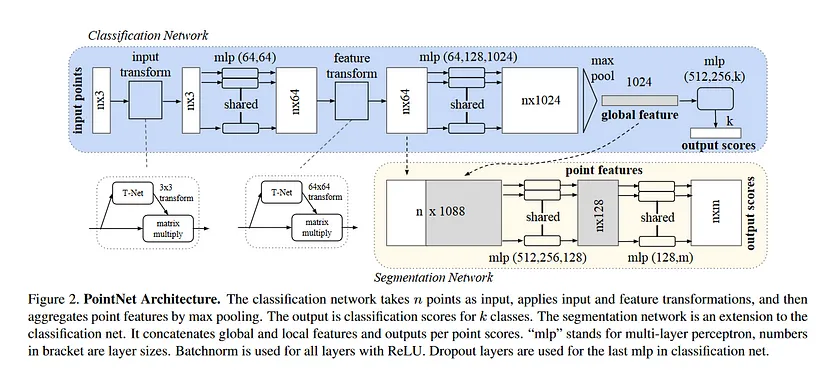

In [4]:
# The model architecture was refactored from this github, which we tweaked for our use case,
# https://github.com/itberrios/3D/blob/main/point_net/point_net.py


# ============================================================================
# T-net (Spatial Transformer Network)
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=16384):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features, 
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their 
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    ''' 
    def __init__(self, num_points=16384, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main 
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation 
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), 
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat



# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=4096, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, crit_idxs, A_feat = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, crit_idxs, A_feat

In [5]:
seg_model = PointNetSegHead(num_points=4096, m=9)
points, targets = next(iter(train_loader))
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

NameError: name 'train_loader' is not defined

# CUSTOMIZED LOSS FOR SEGMENTATION

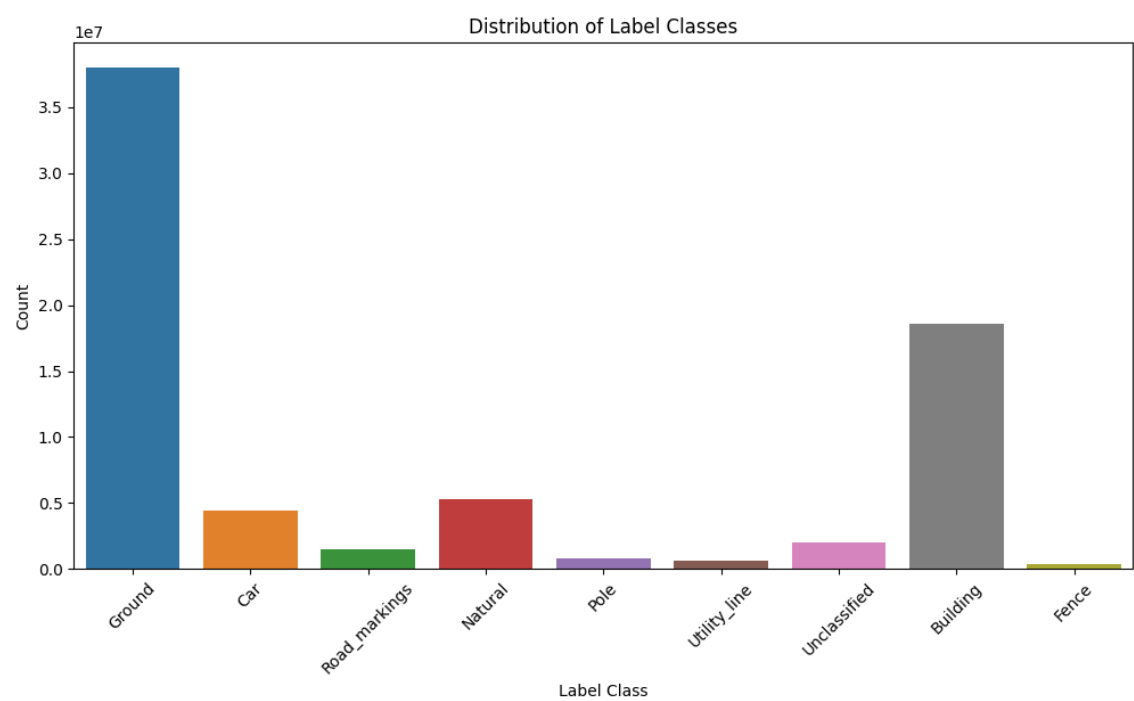

Our dataset is heavily imbalanced, with common categories like "Ground" and "Building" significantly outnumbering the other classes. If we were to train using a standard loss function like Cross Entropy, it would treat all classes as equally important. However, in practice, we want our model to pay more attention to the less common categories and not overly prioritize the more prevalent ones.

To address this imbalance, we will use a custom weighted loss function, adapted from the repository we referenced for the PointNet model [source](https://github.com/itberrios/3D/blob/main/point_net/point_net_loss.py). This approach helps the model focus on the more challenging classes (hard examples) while giving less emphasis to the easier ones.

The core of our loss function is based on Focal Loss, an enhancement of Cross Entropy that is particularly effective for imbalanced datasets. Focal Loss shifts the focus to the sparse set of hard examples, ensuring that the model learns more effectively from them.

In addition, we will incorporate Dice Loss to further improve the Intersection over Union (IoU) performance, ensuring better segmentation accuracy across all classes still following the repository's code.

In [22]:
# special loss for segmentation Focal Loss + Dice Loss
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)
        

    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2)) 
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: loss = loss.mean() 
        else: loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice: return loss + self.dice_loss(targets, pred_choice, eps=1)
        else: return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps)) 

# TRAINING 

In [23]:
# Training hyperparameters

EPOCHS = 3
LR = 0.0001
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# manually set alpha weights
alpha = np.ones(9)
alpha[0] *= 0.8 # balance background classes (ground)
alpha[4] *= 0.6  # balance building class
alpha[4] *= 0.5  # balance building class
alpha[4] *= 0.3  # balance building class

gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, 
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

cuda


For our training we will want to quantify how well our model is performing. Typically we look at loss and accuracy, but for this segmentation problem we will need a metric that accounts for incorrect classification as well as correct classification. The Matthews Correlation Coefficient does this and we will use it to quantify our performance. The MCC ranges from -1 to 1, to understand what the MCC is reporting:

* 0 indicates a random guess
* -1 is the worst possible performance
* 1 is the best possible performance

In [24]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=9).to(DEVICE)

In [25]:
# We also want to track how well the models learns structure, so we will keep track of the IOU

def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [26]:
# store best validation iou
best_iou = 0.7
best_mcc = 0.7

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

In [27]:
import gc

gc.collect()  # Limpia memoria en CPU
torch.cuda.empty_cache()  # Libera memoria en GPU
torch.cuda.ipc_collect()  # Fuerza la recolección de memoria compartida

In [29]:
from collections import defaultdict, Counter

NUM_TRAIN_POINTS = train_dataset.num_points  # Se ajusta dinámicamente según el dataset
BATCH_SIZE = 16

# Calcular número de batches
num_train_batch = int(np.ceil(len(train_dataset) / BATCH_SIZE))
num_valid_batch = int(np.ceil(len(val_dataset) / BATCH_SIZE))

for epoch in range(1, EPOCHS + 1):
    seg_model.train()
    
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []

    for i, (points, targets) in enumerate(train_loader, 0):
        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        
        # Forward pass
        preds, _, _ = seg_model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # Cálculo de pérdida
        loss = criterion(preds, targets, pred_choice)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Cálculo de métricas
        correct = pred_choice.eq(targets.data).cpu().sum()
        total_points = targets.numel()  # Número total de puntos en el batch
        accuracy = correct / float(total_points)

        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # Guardar métricas
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy.item())  
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 500 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # Enfriamiento
    time.sleep(4)

    # **Validación**
    
    with torch.no_grad():
        seg_model.eval()
        
        _valid_loss = []
        predictions_dict = defaultdict(list)  # Diccionario para acumulación de predicciones
        total_correct = 0
        total_points = 0

        for i, (points, targets, original_indices) in enumerate(val_loader, 0):
            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.to(DEVICE)

            preds, _, A = seg_model(points)  # Inferencia
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)  # Selección de clase

            loss = criterion(preds, targets, pred_choice)
            _valid_loss.append(loss.item())

            # Guardar predicciones en el diccionario
            preds_np = pred_choice.cpu().numpy()
            original_indices_np = original_indices.numpy()

            for batch_idx in range(len(original_indices_np)):  # Iteramos por batch
                for point_idx, original_index in enumerate(original_indices_np[batch_idx]):  # Por cada punto
                    predictions_dict[original_index].append(preds_np[batch_idx][point_idx])

        # Agregación de predicciones finales
        final_labels = aggregate_predictions(predictions_dict)

        # Evaluación después de la agregación
        correct = 0
        all_targets = []
        all_preds = []

        for index, final_pred in final_labels.items():
            all_targets.append(ground_truth_labels[index])  # Etiquetas originales
            all_preds.append(final_pred)

            if final_pred == ground_truth_labels[index]:  # Comprobar acierto
                correct += 1

        # Calcular métricas finales
        accuracy = correct / len(final_labels)
        mcc = mcc_metric(torch.tensor(all_preds), torch.tensor(all_targets))
        iou = compute_iou(torch.tensor(all_targets), torch.tensor(all_preds))

        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(accuracy)
        valid_mcc.append(mcc.item())
        valid_iou.append(iou.item())

        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
            + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
            + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
            + f'- Valid IOU: {valid_iou[-1]:.4f}')

        # Enfriamiento
        time.sleep(4)

	 [1: 0/483] train loss: 1.4385 accuracy: 0.5307 mcc: 0.2934 iou: 0.3612
Epoch: 1 - Train Loss: 1.1767 - Train Accuracy: 0.6266 - Train MCC: 0.3725 - Train IOU: 0.4623


RuntimeError: stack expects each tensor to be equal size, but got [4096, 3] at entry 0 and [1841, 3] at entry 8

# MODEL EVALUATION

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(np.arange(1, EPOCHS + 1), train_loss, label='Train Loss')
ax[0, 0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(np.arange(1, EPOCHS + 1), train_accuracy, label='Train Accuracy')
ax[0, 1].plot(np.arange(1, EPOCHS + 1), valid_accuracy, label='Validation Accuracy')
ax[0, 1].set_title('Accuracy')
ax[0, 1].legend()

ax[1, 0].plot(np.arange(1, EPOCHS + 1), train_mcc, label='Train MCC')
ax[1, 0].plot(np.arange(1, EPOCHS + 1), valid_mcc, label='Validation MCC')
ax[1, 0].set_title('MCC')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(1, EPOCHS + 1), train_iou, label='Train IoU')
ax[1, 1].plot(np.arange(1, EPOCHS + 1), valid_iou, label='Validation IoU')
ax[1, 1].set_title('IoU')
ax[1, 1].legend()

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

In [ ]:
torch.save(seg_model, "full_segmentation_model_2.pth")

In [ ]:
torch.save(seg_model.state_dict(), "segmentation_model_2.pth")

# MODEL TESTING

In [ ]:
import gc
import torch

# Clear unnecessary variables
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import os
import glob

model_dir = '/kaggle/working/trained_models'
files = glob.glob(os.path.join(model_dir, '*.pth'))

latest_model = files[-1]
latest_model

In [ ]:
MODEL_PATH = latest_model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
NUM_TEST_POINTS = 8192

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(DEVICE)

In [ ]:
test_dataset = PointCloudDataset(test_df, augmentation=False, num_points=NUM_TEST_POINTS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_loader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

In [ ]:
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

In [ ]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

In [ ]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(category_mapping.values()),
                              index=list(category_mapping.values()))

test_confusion

In [ ]:
# Plot the heatmap
category_labels = list(category_mapping.values())
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()